In [2]:
import numpy as np
import pandas as pd

from flagger import PLFlagger, PLNNFlagger
from flagger_tools import PLFlaggerTest
from flagger_tools import get_sampler_data
from matplotlib import pyplot as plt

<string>:11: SyntaxWarning: invalid escape sequence '\s'
<string>:193: SyntaxWarning: invalid escape sequence '\s'


### Real World Data

Create sampler from data

In [4]:
r = 0.2
P0 = pd.read_csv("Data/sample_reference_group.csv")
P1 = pd.read_csv("Data/sample_critical_group.csv")
sampler = get_sampler_data(r, P0, P1)

In [96]:
tmvbeta0 = TMVBeta(np.ones(3), np.ones(3), np.eye(3), x_min=np.array([0.13, 0.7, 0.3]))
tmvbeta1 = TMVBeta(np.ones(3), np.ones(3), np.eye(3), x_min=np.array([0.13, 0.7, 0.3]))

In [97]:
tmvbeta0.fit(P0)
tmvbeta1.fit(P1)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -3.9559437736152026
             x: [ 1.089e+00  5.304e+00  1.973e+00  6.070e+00  2.794e+00
                  3.637e+00  8.908e-01  9.271e-01  8.923e-01]
           nit: 820
          nfev: 2324
 final_simplex: [[ 1.089e+00  5.304e+00 ...  9.271e-01  8.923e-01]
                 [ 1.089e+00  5.304e+00 ...  9.271e-01  8.923e-01]
                 ...
                 [ 1.089e+00  5.304e+00 ...  9.271e-01  8.923e-01]
                 [ 1.089e+00  5.304e+00 ...  9.271e-01  8.923e-01]]

In [98]:
tmvbeta0.update(x_min=None)
tmvbeta1.update(x_min=None)

In [100]:
sampler = get_sampler_model(r, tmvbeta0, tmvbeta1)

Initialize Bayes and SVM flagger

In [34]:
K = 60
M = 3
N = 100
T = 100

In [113]:
pl_flagger_svm = PLFlagger(K, M)
pl_flagger_lr = PLFlagger(K, M, "log_loss")

In [114]:
test_svm = PLFlaggerTest(pl_flagger_svm, sampler, N, 20)
test_lr = PLFlaggerTest(pl_flagger_lr, sampler, N, 20)

In [115]:
total_svm = np.zeros((20, T + 1))
total_lr = np.zeros((20, T + 1))

detected_svm = np.zeros((20, T + 1))
detected_lr = np.zeros((20, T + 1))
        
for n in range(20):
    total_svm[n], detected_svm[n] = test_svm.run(T)
    total_lr[n], detected_lr[n] = test_lr.run(T)

rate_svm = np.mean(detected_svm[:, 1:] / total_svm[:, 1:], axis=0)
rate_lr = np.mean(detected_lr[:, 1:] / total_lr[:, 1:], axis=0)

In [116]:
rate_svm[-1], rate_lr[-1]

(np.float64(0.5240811690436866), np.float64(0.5267574005807673))

In [27]:
save_to_gnuplot(f"detection_rate_svm_{K}_no_mismatch.dat", range(1, T+1), rate_svm)
save_to_gnuplot(f"detection_rate_lr_{K}_no_mismatch.dat", range(1, T+1), rate_lr)

In [27]:
rate_lr_max = 0.0
for lr in 10 ** np.linspace(-4, 1, 50):
    pl_flagger_lr = PLFlagger(K, M, lr=lr, loss="log_loss")
    test_lr = PLFlaggerTest(pl_flagger_lr, sampler, N, 10)
        
    total_lr = np.zeros((20, T + 1))
    detected_lr = np.zeros((20, T + 1))
    
    for n in range(20):
        total_lr[n], detected_lr[n] = test_lr.run(T)

    rate_lr = np.mean(detected_lr[:, 1:] / total_lr[:, 1:], axis=0)

    if rate_lr[-1] > rate_lr_max:
        print(lr, rate_lr[-1])
        rate_lr_max = rate_lr[-1]
        save_to_gnuplot(f"detection_rate_lr_{K}_real.dat", range(1, T+1), rate_lr)

0.0001 0.07676441200605735
0.00040949150623804275 0.07745456706943607
0.0021209508879201904 0.09451115467109814
0.47148663634573945 0.10170005736345819
0.7543120063354622 0.1856484927339327
1.2067926406393288 0.26024470857006776
1.5264179671752334 0.3265838322782982
2.44205309454865 0.44969209943416966
4.941713361323838 0.47579178792058335
7.9060432109077015 0.4879195757461988
10.0 0.4897204032198615


In [22]:
rate_sv_max = 0.0
for lr in 10 ** np.linspace(-4, 1, 50):
    pl_flagger_sv = PLFlagger(K, M, lr=lr)
    test_sv = PLFlaggerTest(pl_flagger_sv, sampler, N, 10)
        
    total_sv = np.zeros((20, T + 1))
    detected_sv = np.zeros((20, T + 1))
    
    for n in range(20):
        total_sv[n], detected_sv[n] = test_sv.run(T)

    rate_sv = np.mean(detected_sv[:, 1:] / total_sv[:, 1:], axis=0)

    if rate_sv[-1] > rate_sv_max:
        print(lr, rate_sv[-1])
        rate_sv_max = rate_sv[-1]
        save_to_gnuplot(f"detection_rate_sv_{K}_real.dat", range(1, T+1), rate_sv)

0.0001 0.31281912527071154
0.00012648552168552957 0.3179111196684691
0.00040949150623804275 0.32255392012123135
0.0010481131341546852 0.3246167133572029
0.0016768329368110084 0.3309599175937762
0.0021209508879201904 0.33224027471058293
0.002682695795279727 0.33637636265173965
0.00339322177189533 0.34637109185811993
0.004291934260128779 0.3497892797173947
0.005428675439323859 0.3734560348853592
0.006866488450042998 0.38542091762739905
0.008685113737513529 0.44907450595149295
0.010985411419875584 0.5322877862313752
0.013894954943731374 0.5888030933848833
0.01757510624854793 0.6441382813929459
0.022229964825261957 0.6949546022949701
0.028117686979742307 0.7283917328232365
0.03556480306223129 0.7612829813567036
0.04498432668969444 0.7801260177456416
0.05689866029018299 0.8023110036575968
0.07196856730011521 0.8205299398688911
0.09102981779915217 0.8422952379650264
0.11513953993264481 0.8530153014239913
0.14563484775012445 0.863347132018928
0.18420699693267165 0.8686243703794017
0.232995181

In [36]:
rate_nn_max = 0.0
for lr in 10 ** np.linspace(-5, 1, 60):
    for n_hidden in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
        pl_flagger_nn = PLFlaggerNN(K, M, lr=lr, n_hidden=n_hidden)
        test_nn = PLFlaggerTest(pl_flagger_nn, sampler, N, 10)
        
        total_nn = np.zeros((20, T + 1))
        detected_nn = np.zeros((20, T + 1))
        
        for n in range(20):
            total_nn[n], detected_nn[n] = test_nn.run(T)

        rate_nn = np.mean(detected_nn[:, 1:] / total_nn[:, 1:], axis=0)

        if rate_nn[-1] > rate_nn_max:
            print(lr, n_hidden, rate_nn[-1])
            rate_nn_max = rate_nn[-1]
            save_to_gnuplot(f"detection_rate_nn_{K}_real.dat", range(1, T+1), rate_nn)

1e-05 2 0.6013701492574419
1e-05 4 0.6411580386388893
1e-05 6 0.7011433493344621
0.47639380104013407 5 0.7152628968945338


Initialize testing classes

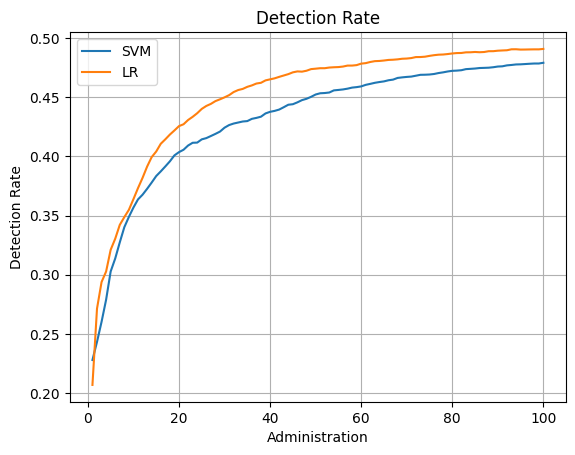

In [9]:
plt.plot(range(1, T+1), rate_svm, label="SVM")
plt.plot(range(1, T+1), rate_lr, label="LR")
plt.title("Detection Rate")
plt.ylabel("Detection Rate")
plt.xlabel("Administration")
plt.legend()
plt.grid()

Plot posterior means of $R$

In [8]:
r_est_pol_1 = np.array([model.v[1] / model.v.sum() for model in model_pol_1])
r_est_pol_3 = np.array([model.v[1] / model.v.sum() for model in model_pol_3])

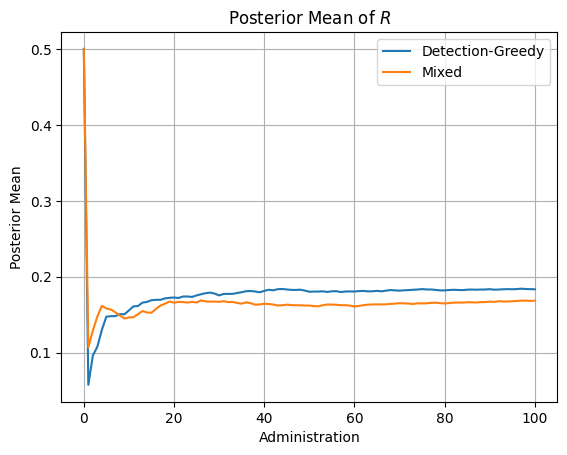

In [9]:
plt.plot(range(T+1), r_est_pol_1, label="Detection-Greedy")
plt.plot(range(T+1), r_est_pol_3, label="Mixed")
plt.title(r"Posterior Mean of $R$")
plt.ylabel("Posterior Mean")
plt.xlabel("Administration")
plt.legend()
plt.grid()